In [301]:
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.base import clone
import numpy as np

In [302]:
X, y = make_circles(n_samples=500, noise=0.1, random_state=42, factor=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

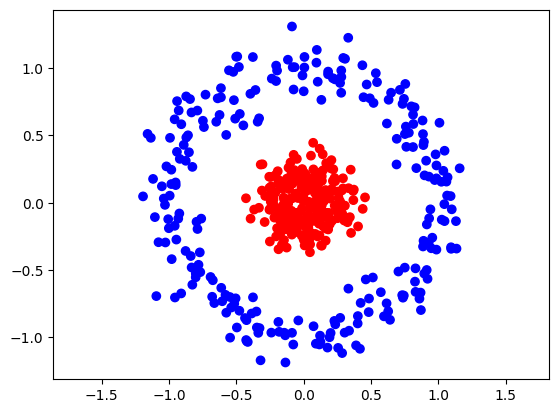

In [303]:
# Plotting
plt.scatter(X[:,0], X[:,1], c=y, cmap=colors.ListedColormap(["blue", "red"]))
plt.axis('equal')
plt.show()

In [304]:
print(np.unique(y))
# To convert 0 -> -1 for ADA BOOST algorithm
print(f"No of points labelled 1: {len(y[y==1])}, No of points labelled 0: {len(y[y==0])}")

[0 1]
No of points labelled 1: 250, No of points labelled 0: 250


In [305]:
y[y==0] = -1
np.unique(y)

array([-1,  1], dtype=int64)

In [306]:
print(f"No of points labelled 1: {len(y[y==1])}, No of points labelled -1: {len(y[y==-1])}")

No of points labelled 1: 250, No of points labelled -1: 250


In [307]:
class AdaBoost:
    def __init__(self, base_classifier, itr = 25, eta = 0.5):
        self.itr = itr
        self.eta = eta
        self.base_classifier = base_classifier
        
    def fit(self,X,Y):
        # To initialize the initial weights of each datapoint
        No_Samples  = len(X)
        w = np.full(No_Samples, 1/No_Samples)
        
        # To store each weak classifier and its corresponding weight
        self.classifer = [] 
        self.alpha = []
        
        for i in range(self.itr):
            
            # Fitting the weak classifier i.e., Log Regression
            Classifier = clone(self.base_classifier)
            Classifier.fit(X, Y, sample_weight=w)

            Classifier_predict = Classifier.predict(X)
            
            # To compute error : Sum of weights of all the incorrectly classified points
            error = np.sum(w* (Classifier_predict!=Y))
            
            # Alpha
            Alpha = 0.5 * np.log((1 - error)/ (error + 1e-10))
            # 1e-10 added to avoid division by zero error, it doesn't affect the log term value.
            
            # SToring classifier and its weights(alpha)
            self.classifer.append(Classifier)
            self.alpha.append(Alpha)
            
            w = w*np.exp(-Alpha * Y * Classifier_predict)
            w = w/np.sum(w)
            
            #plot_decision_boundary(self.classifer, X, Y)
    
    def Predict(self, X):
        y_pred = np.zeros(X.shape[0])
        
        for classifier, alpha in zip(self.classifer, self.alpha):
            y_pred = y_pred+ self.eta*alpha*classifier.predict(X)
        return np.sign(y_pred)
    

In [308]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.45, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.Predict(X_new).reshape(x1.shape)

    custom_cmap = ListedColormap(['#ffcccc', '#cce5ff'])  
    plt.contourf(x1, x2, y_pred, alpha=0.5, cmap=custom_cmap)
    
    if contour:
        custom_cmap2 = ListedColormap(['#990000', '#003366']) 
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    
    plt.plot(X[:, 0][y == -1], X[:, 1][y == -1], "o", color='orange', alpha=alpha, label='Class -1')  # Class -1
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "o", color='blue', alpha=alpha, label='Class 1')  # Class 1
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    plt.legend()
    plt.title("Final Ensembled Classifier Decision Boundary")
    plt.show()


In [309]:
def plot_all_decision_boundaries(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.45, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]

    custom_cmap = ListedColormap(['#ffcccc', '#cce5ff'])  
    plt.contourf(x1, x2, clf.Predict(X_new).reshape(x1.shape), alpha=0.5, cmap=custom_cmap)

    if contour:
        colors = ['#FF5733', '#33FF57', '#3357FF', '#F39C12', '#8E44AD', '#1ABC9C', '#D35400', '#C0392B', '#27AE60', '#2980B9', '#9B59B6', '#E74C3C', '#F1C40F']

        for i, classifier in enumerate(clf.classifer):
            if i >= len(colors):
                color = '#8E44AD' 
            else:
                color = colors[i % len(colors)]
            
            y_pred = classifier.predict(X_new).reshape(x1.shape)
            plt.contour(x1, x2, y_pred, colors=[color], alpha=0.8, linestyles='--', linewidths=1)

    plt.plot(X[:, 0][y == -1], X[:, 1][y == -1], "o", color='orange', alpha=alpha, label='Class -1')  # Class -1
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "o", color='blue', alpha=alpha, label='Class 1')  # Class 1
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    plt.legend()
    plt.title("AdaBoost Ensemble Decision Boundaries(Classifier Fit at every Iteration)")
    plt.show()


### 1. Decision Stump (Decision Tree of depth 1)

In [310]:
from sklearn.tree import DecisionTreeClassifier

In [311]:
k = 0
max_accuracy = 0
for i in range(1, 16):
    c = AdaBoost(DecisionTreeClassifier(max_depth=1),i)
    c.fit(X,y)
    Y = c.Predict(X)
    accuracy = np.mean(y == Y)
    if(accuracy>max_accuracy):
        k = i
        max_accuracy = accuracy
        
print(f"Accuracy: {max_accuracy * 100:.2f}% for No of Classifiers in Ensemble:{k}")

Accuracy: 100.00% for No of Classifiers in Ensemble:13


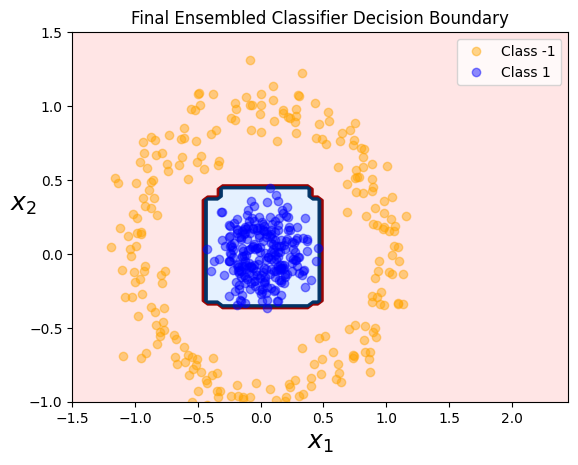

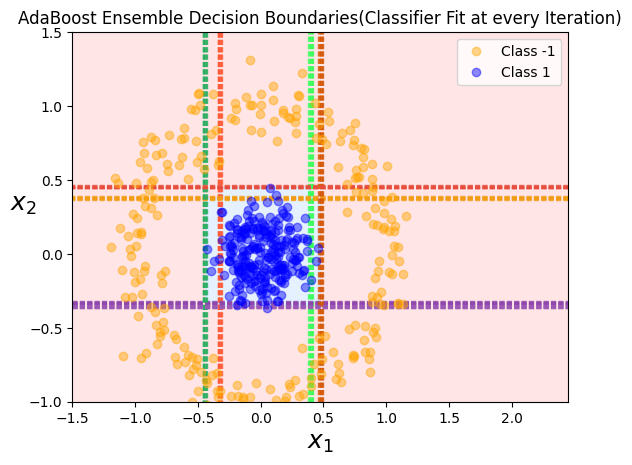

In [312]:
# Plotting
c = AdaBoost(DecisionTreeClassifier(max_depth=1), 13)
c.fit(X,y)
plot_decision_boundary(c, X, y)
plot_all_decision_boundaries(c, X, y)
Y = c.Predict(X)
accuracy = np.mean(y == Y)

### 2. Decision Tree of depth 3

In [313]:
k =0 
max_accuracy = 0

for i in range(1, 6):
    c = AdaBoost(DecisionTreeClassifier(max_depth=3),i)
    c.fit(X,y)
    Y = c.Predict(X)
    accuracy = np.mean(y == Y)
    if(accuracy>max_accuracy):
        k = i
        max_accuracy = accuracy
print(f"Accuracy: {max_accuracy * 100:.2f}% for No of Classifiers in Ensemble:{k}")

Accuracy: 100.00% for No of Classifiers in Ensemble:3


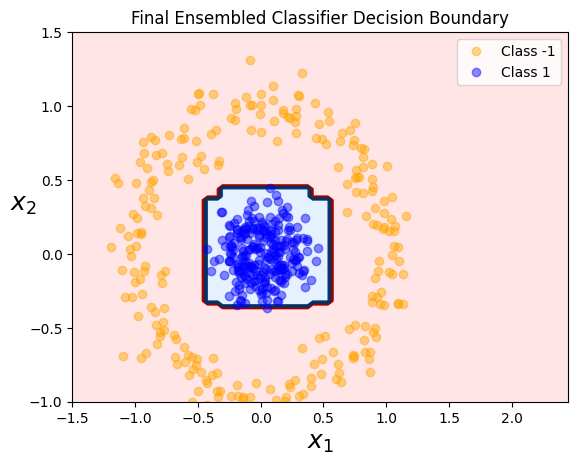

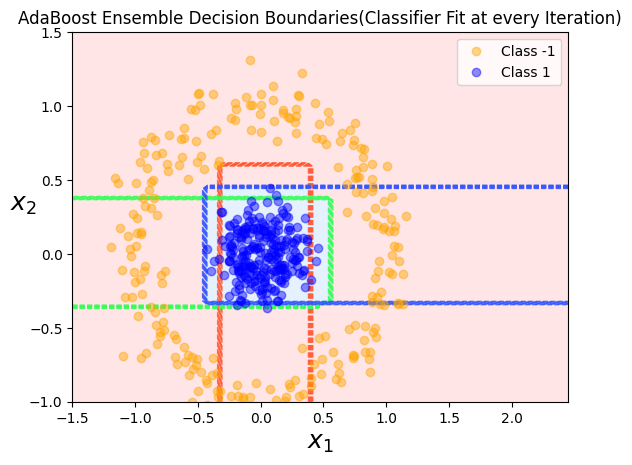

In [314]:
# Plotting
c = AdaBoost(DecisionTreeClassifier(max_depth=3), 3)
c.fit(X,y)
plot_decision_boundary(c, X, y)
plot_all_decision_boundaries(c, X, y)
Y = c.Predict(X)
accuracy = np.mean(y == Y)

### 3. Logistic Regression

In [315]:
from sklearn.linear_model import LogisticRegression

In [316]:
max_accuracy = 0
k = 0
for i in range(1, 100):
    c = AdaBoost(LogisticRegression(solver='newton-cg', max_iter=10),i)
    c.fit(X,y)
    Y = c.Predict(X)
    accuracy = np.mean(y == Y)
    if(accuracy>max_accuracy):
        k = i
        max_accuracy = accuracy
    
print(f"Accuracy: {max_accuracy * 100:.2f}% for No of Classifiers in Ensemble:{k}")

Accuracy: 99.20% for No of Classifiers in Ensemble:61


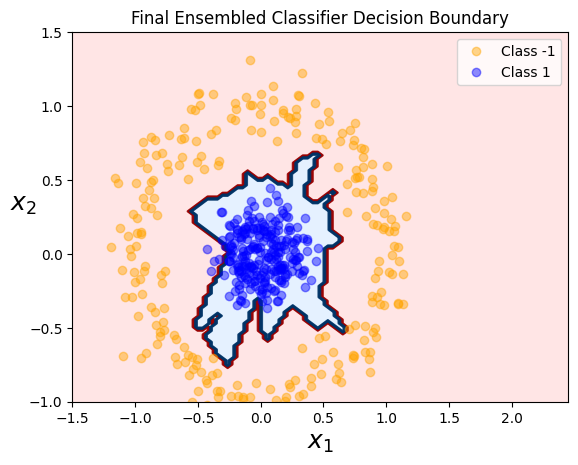

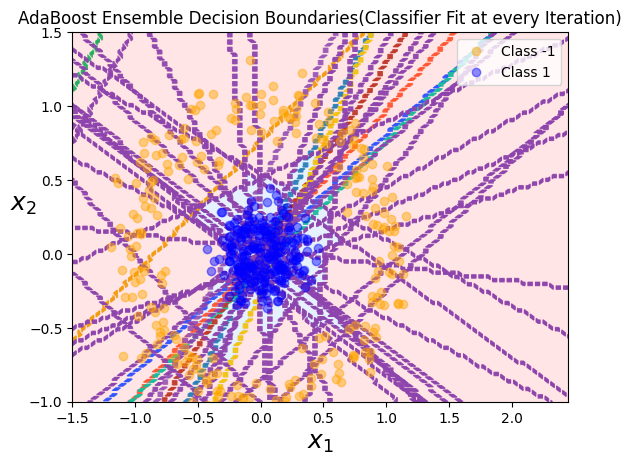

In [317]:
# Plotting
c = AdaBoost(LogisticRegression(solver='newton-cg', max_iter=10), 61)
c.fit(X,y)
plot_decision_boundary(c, X, y)
plot_all_decision_boundaries(c, X, y)
Y = c.Predict(X)
accuracy = np.mean(y == Y)

### 4. Linear SVM


In [318]:
from sklearn.svm import LinearSVC

In [319]:
max_accuracy = 0
k = 0
for i in range(1, 100):
    c = AdaBoost(LinearSVC(penalty='l2',C=0.1),i)
    c.fit(X,y)
    Y = c.Predict(X)
    accuracy = np.mean(y == Y)
    if(accuracy>max_accuracy):
        k = i
        max_accuracy = accuracy
    
print(f"Accuracy: {max_accuracy * 100:.2f}% for No of Classifiers in Ensemble:{k}")

Accuracy: 98.80% for No of Classifiers in Ensemble:48


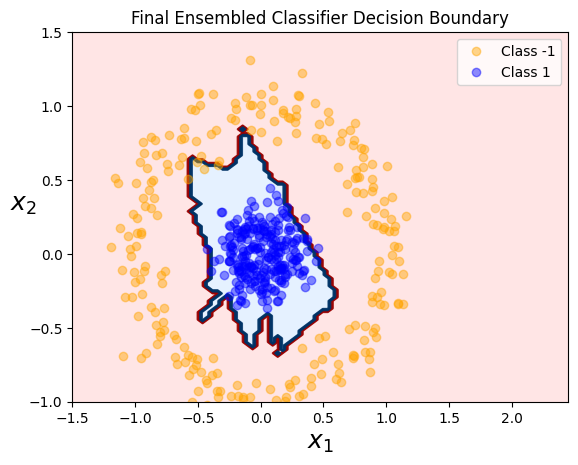

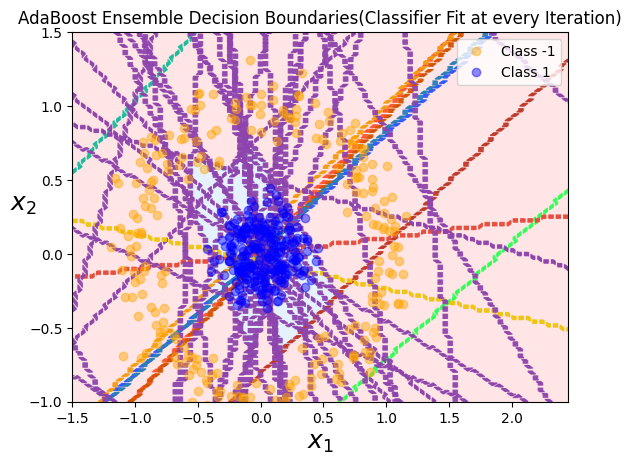

In [320]:
# Plotting
c = AdaBoost(LinearSVC(C=0.1, penalty='l2'), 48)
c.fit(X,y)
plot_decision_boundary(c, X, y)
plot_all_decision_boundaries(c, X, y)


### 5. LDA

In [321]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [322]:
class AdaBoost:
    def __init__(self, base_classifier, itr = 25, eta = 0.5):
        self.itr = itr
        self.eta = eta
        self.base_classifier = base_classifier
        
    def fit(self,X,Y):
        # To initialize the initial weights of each datapoint
        No_Samples  = len(X)
        w = np.full(No_Samples, 1/No_Samples)
        
        # To store each weak classifier and its corresponding weight
        self.classifer = [] 
        self.alpha = []
        
        for i in range(self.itr):
            
            # Sampling the Data based on the updated weights such that the misclassified data points appear more in the new dataset.
            indices = np.random.choice(np.arange(No_Samples), size=No_Samples, replace=True, p=w)
            X_sampled = X[indices]
            Y_sampled = Y[indices]
            
            # Fitting the weak classifier i.e., Log Regression
            Classifier = clone(self.base_classifier)
            Classifier.fit(X_sampled, Y_sampled)

            Classifier_predict = Classifier.predict(X)
            
            # To compute error : Sum of weights of all the incorrectly classified points
            error = np.sum(w* (Classifier_predict!=Y))
            
            # Alpha
            Alpha = 0.5 * np.log((1 - error)/ (error + 1e-10))
            # 1e-10 added to avoid division by zero error, it doesn't affect the log term value.
            
            # SToring classifier and its weights(alpha)
            self.classifer.append(Classifier)
            self.alpha.append(Alpha)
            
            w = w*np.exp(-Alpha * Y * Classifier_predict)
            w = w/np.sum(w)
            
            
            
            #plot_decision_boundary(self.classifer, X, Y)
    
    def Predict(self, X):
        y_pred = np.zeros(X.shape[0])
        
        for classifier, alpha in zip(self.classifer, self.alpha):
            y_pred = y_pred+ self.eta*alpha*classifier.predict(X)
        return np.sign(y_pred)
    

In [299]:
max_accuracy = 0
k = 0
for i in range(1, 150):
    c = AdaBoost(LDA(solver='lsqr', shrinkage=0.5),i)
    c.fit(X,y)
    Y = c.Predict(X)
    accuracy = np.mean(y == Y)
    if(accuracy>max_accuracy):
        k = i
        max_accuracy = accuracy
    
print(f"Accuracy: {max_accuracy * 100:.2f}% for No of Classifiers in Ensemble:{k}")

Accuracy: 98.40% for No of Classifiers in Ensemble:149


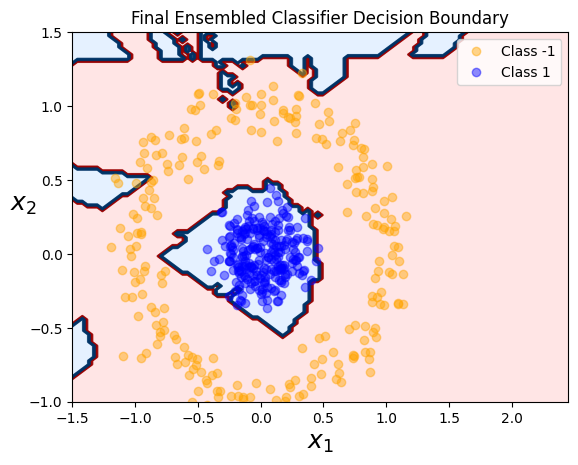

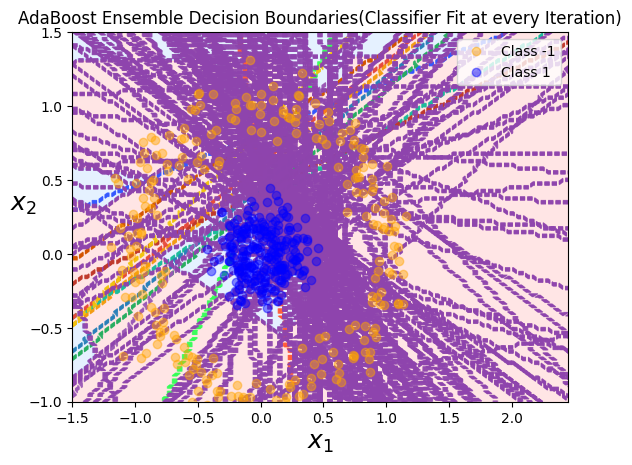

In [300]:
# Plotting
plot_decision_boundary(c, X, y)
plot_all_decision_boundaries(c, X, y)


The AdaBoost algorithm is run with 5 different weak classifier on a dataset which has non linearity.
The Decision stump, Decision tree with depth 3, Logistic regression and Linear SVM accepts sample weights as a parameter during the fit function where the function focuses on the datapoints having higher weights to be classified correctly. They do not require resampling of the original dataset they focus on the datapoints from the original dataset.

The LDA doesn't support the sample weight parameter therefore the AdaBoost class is modified where the dataset is sampled with replacement during each iteration and the dataset would be populated by the points with higher weights forcing the model to learn and classify the points correctly. The model is fit with the sampled data, the predictions are made on the original data to check it's corresponding generalization capability. Based on the errors on the original data the weights of the datapoints are changed accordingly. 

The paramters of the classifiers are chosen after perfoming grid search with different values and evaluating the performances accordingly. 

The Final ensembled decision boundary and the classifier fit at every iteration is plotted for each of the chosen weak classifier.